<h1>Imports, Parameters, and Helper Functions</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy as sp
import scipy.io as sio
import csv
import matplotlib as mpl
from matplotlib import widgets
import pickle
from matplotlib.patches import Patch
import time
import torch 
import multiprocess as mp
import networkx as nx

%matplotlib ipympl

# x ̈ + 0.085x ̇ − 0.5x + 0.2x3 = γ cos(0.42t).
delta = 0.085
k1 = -0.5
k3 = 0.2
omega = 0.42
Tperiod = 2*np.pi/omega
gamma = 0.15

def duffing_RHS(t, x, g):
    dxdt = x[1]
    dvdt = -delta * x[1] - k1 * x[0] - k3 * x[0]**3 + g * np.cos(omega * t)
    dxdt = np.array([dxdt, dvdt])
    return dxdt

duff = lambda t, y: duffing_RHS(t, y, gamma)

def RKStep(y, t, RHS, h):
    h2 = 0.5*h
    k1 = RHS(t, y)
    k2 = RHS(t+h2, y+h2*k1)
    k3 = RHS(t+h2, y+h2*k2)
    k4 = RHS(t+h, y+h*k3)
    tnew = t + h
    ynew = y + h*(k1+2*(k2+k3)+k4)/6
    return ynew, tnew

def Stoch_RKStep(y, t, RHS, h, sigma=0):
    mytime = time.time()
    ynew, tnew = RKStep(y, t, RHS, h)
    if sigma>0:
        dW = np.random.normal(size=1)*np.sqrt(h)*sigma
        ynew[1] += dW[0]
    return ynew, tnew

def plot_ellipse(xc, cov):
    g = np.linspace(0, 2 * np.pi, 100)  # for plotting ellipses
    E, V = np.linalg.eig(cov)
    isort = np.argsort(np.sqrt(E))[::-1]
    V = V[:, isort]
    R = np.sqrt(E[isort])
    a = np.angle(V[0, 0] + 1j * V[1, 0])
    x = R[0] * np.cos(a) * np.cos(g) - R[1] * np.sin(a) * np.sin(g) + xc[0]
    p = R[0] * np.sin(a) * np.cos(g) + R[1] * np.cos(a) * np.sin(g) + xc[1]
    return(x, p)

def plot_circle(xc, r):
    return plot_ellipse(xc, np.array([[1, 0],[0,1]])*r)

def means_and_covariances(Nruns_per_point, steps_per_period, dt, sigma, duff, y0, retall=True):
    X = np.zeros((Nruns_per_point,2))
    for k in range(Nruns_per_point):
        t = 0
        y = y0
        for j in range(steps_per_period):
            y, t = Stoch_RKStep(y, t, duff, dt, sigma)
        X[k,:] = y
    Xmean = np.mean(X,0)
    Xc = X-np.ones((Nruns_per_point,1))*Xmean
    Xcov = Xc.T@Xc/Nruns_per_point
    evals = np.sort(np.linalg.eig(Xcov)[0])
    if retall:
        return Xmean, Xcov, evals
    else: 
        return evals

<h1>Finding Attractors</h1>
<p>Part of this is heuristic for each value of $\gamma$.</p>

<h2>Defining Functions</h2>

In [5]:
def OnePeriodMap(yi, RHS, Tper, AbsTol, RelTol):
    sol = solve_ivp(RHS, [0.0, Tper], yi, method = 'RK45',
                    t_eval = [0, Tper], atol = AbsTol, rtol = RelTol)
    return sol.y[0][-1], sol.y[1][-1]

def find_periodic_attractor(y_iguess, RHS, Tper, tol, printflag=False): #implimentation of Newton's Method
    AbsTol = 1.0e-12
    RelTol = 1.0e-12
    h = 1.0e-6
    G0, G1 = OnePeriodMap(y_iguess, RHS, Tper, AbsTol, RelTol)
    res = np.linalg.norm(y_iguess - np.array([G0, G1]))
    itermax = 20
    J = np.zeros((2, 2)) #Jacobian
    y0 = y_iguess[0]
    y1 = y_iguess[1]
    iter = 0
    if printflag:
        print(f'iter: {iter}, res: {res}')
    while res > tol and iter < itermax:
        #first we must compute the jacobian matrix
        #perturb the x direction
        G0_shift0, G1_shift0 = OnePeriodMap([y0+h, y1],RHS,Tper,AbsTol,RelTol)
        #perturb the v direction 
        G0_shift1, G1_shift1 = OnePeriodMap([y0, y1+h],RHS,Tper,AbsTol,RelTol)
        J[0,0] = 1-(G0_shift0-G0)/h
        J[0,1] = -(G0_shift1-G0)/h
        J[1,0] = -(G1_shift0-G1)/h
        J[1,1] = 1-(G1_shift1-G1)/h

        ynew = [y0, y1] - np.linalg.solve(J, np.array([y0, y1])-np.array([G0, G1]))
        res = np.linalg.norm([y0, y1]-ynew)
        y0 = ynew[0]
        y1 = ynew[1]
        G0, G1 = OnePeriodMap(ynew, RHS, Tper, AbsTol, RelTol)
        iter += 1
        if printflag:
            print(f'iter: {iter}, res: {res}')
    return [y0, y1]

def attractor(x0, pf = False): #Pairs newtons method with iterating a few times to ensure a good starting guess
    Nperiods = 50
    Tperiod = 2*np.pi/omega 
    Tmax = Nperiods*Tperiod
    t_store = np.arange(0.0, Tmax, Tperiod)
    solution = solve_ivp(lambda t, x: duffing_RHS(t, x, 0.15), [0.0, Tmax], x0,
                         method='RK45', t_eval = t_store, atol = 1.0e-12, rtol = 1.0e-12).y
    approaches = find_periodic_attractor([solution[0,-1], solution[1,-1]], 
                                                lambda t, x: duffing_RHS(t, x, 0.15), 
                                                Tperiod, 1.0e-9, printflag = pf)
    return approaches

<p>This code produces a list of attractors.

In [6]:
num_attractors = 3 #depends on the parameters of the system 
pot_attractor_nbhoods = set()
while len(pot_attractor_nbhoods)<num_attractors:
    random_point = np.random.rand(2)
    random_point[0] = random_point[0]*6-3
    random_point[1] = random_point[1]*2.5-1.25
    pot_attr = tuple(np.around(attractor(random_point), decimals=4))
    pot_attractor_nbhoods.add(pot_attr)
attractors = {tuple(attractor(x)) for x in pot_attractor_nbhoods}
attractors


{(-1.3212296271972483, 0.017955089952137463),
 (1.1244793491983067, 0.9083082471032553),
 (1.690722433390198, -0.017285507621586385)}

<h2>Attractors</h2>

In [7]:
attractors_dict = {
    'nlaa': (-1.3212296271972483, 0.017955089952137463),
    'plaa': (1.690722433390198, -0.017285507621586385),
    'haa': (1.1244793491983067, 0.9083082471032553)
}
colors_dict = {
    'nlaa': 'g',
    'plaa': 'b',
    'haa': 'y'
}
labels_dict = {
    'nlaa': 'Negative Low-Amplitude Attractor',
    'plaa': 'Positive Low-Amplitude Attractor',
    'haa': 'High-Amplitude Attractor'
}

<h1>Plotting Stochastic Trajectories</h1>
<p>Here we wish to observe some stochastic trajectories. 

<h2>Test Case</h2>

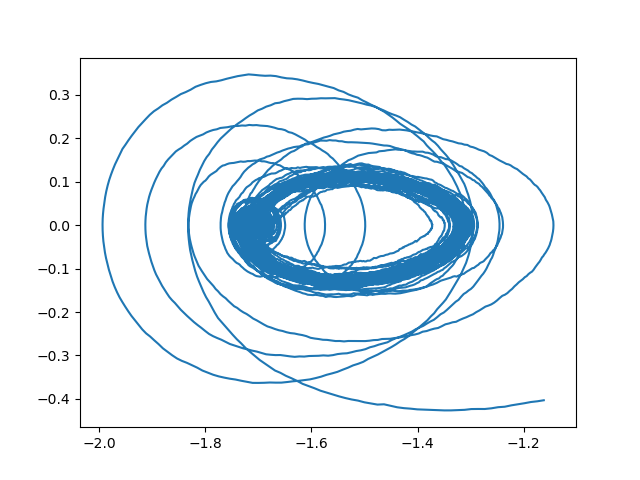

In [8]:
#Test Case
steps_per_period = 500
dt = Tperiod/steps_per_period
periods = 50 
y = np.array((-1.15, -.4))
y_coords = np.zeros((steps_per_period*periods, 2))
y_coords[0] = y

sigma_stochtraj=0.005 # standard deviation of standard weiner process
for n in range(periods):
    t = 0
    for j in range(steps_per_period):
        y,t = Stoch_RKStep(y,t,duff,dt,sigma_stochtraj)
        y_coords[steps_per_period*n+j, :] = y



fig, ax = plt.subplots()
ax.plot(y_coords[:,0], y_coords[:,1])
plt.show()

<h2>Interactive Plot</h2>

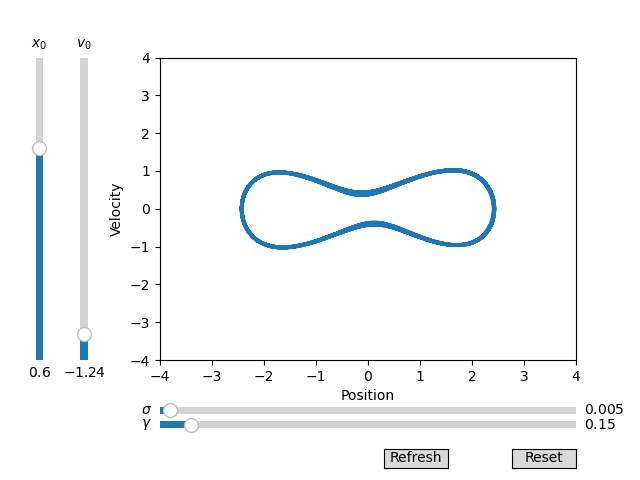

In [9]:
#With Sliders
from matplotlib.widgets import Slider, Button

#our function to plot the curves is plotcurve(y0, gamma, sigma)
def plotcurve(y0, gamma, sigma=0):
    steps_per_period = 500
    dt = Tperiod/steps_per_period
    period_skip = 50
    period_keep = 50
    y_coords = np.zeros((steps_per_period*period_keep, 2))
    y = y0 
    for n in range(period_skip):
        t = 0
        for j in range(steps_per_period):
            y,t = Stoch_RKStep(y,t,lambda t, y: duffing_RHS(t, y, gamma),dt,sigma)

    for n in range(period_keep):
        t = 0
        for j in range(steps_per_period):
            y,t = Stoch_RKStep(y,t,lambda t, y: duffing_RHS(t, y, gamma),dt,sigma)
            y_coords[steps_per_period*n+j,:] = y
    return y_coords


init_x0 = 0.6
init_v0 = -1.24
init_gamma = 0.15
init_sigma = 0.005

acfig, acax = plt.subplots()
acax.set_xlim(-4, 4)
acax.set_ylim(-4, 4)
init_curve = plotcurve([init_x0, init_v0], init_gamma, init_sigma)
line, = acax.plot(init_curve[:,0], init_curve[:,1], lw=2)
acax.set_xlabel('Position')
acax.set_ylabel('Velocity')
acfig.subplots_adjust(left=0.25, bottom=0.25)

ax_gamma = acfig.add_axes([0.25, 0.1, 0.65, 0.03])
gamma_slider = Slider(
    ax = ax_gamma,
    label = '$\gamma$',
    valmin = 0.0,
    valmax = 2.0,
    valinit = init_gamma
)

ax_sigma = acfig.add_axes([0.25, 0.13, 0.65, 0.03])
sigma_slider = Slider(
    ax = ax_sigma,
    label = '$\sigma$',
    valmin = 0.0,
    valmax = 0.2,
    valinit = init_sigma
)

ax_x0 = acfig.add_axes([0.05, 0.25, 0.0225, 0.63])
x0_slider = Slider(
    ax = ax_x0,
    label = '$x_0$',
    valmin = -1.5, 
    valmax = 1.5,
    valinit = init_x0,
    orientation = 'vertical'
)

ax_v0 = acfig.add_axes([0.12, 0.25, 0.0225, 0.63])
v0_slider = Slider(
    ax = ax_v0,
    label = '$v_0$',
    valmin = -1.5, 
    valmax = 1.5,
    valinit = init_v0,
    orientation = 'vertical'
)

def update(val):
    new_curve = plotcurve([x0_slider.val, v0_slider.val], gamma_slider.val, sigma_slider.val)
    line.set_xdata(new_curve[:,0])
    line.set_ydata(new_curve[:,1])
    acfig.canvas.draw_idle()

gamma_slider.on_changed(update)
sigma_slider.on_changed(update)
x0_slider.on_changed(update)
v0_slider.on_changed(update)

resetax = acfig.add_axes([0.8, 0.025, 0.1, 0.04])
button1 = Button(resetax, 'Reset', hovercolor='0.975')
refreshax = acfig.add_axes([0.6, 0.025, 0.1, 0.04])
button2 = Button(refreshax, 'Refresh', hovercolor = '0.975')

def reset(event):
    x0_slider.reset()
    v0_slider.reset()
    gamma_slider.reset()
    sigma_slider.reset()
button1.on_clicked(reset)
button2.on_clicked(update)

plt.show()

<h1>Naive Sampling</h1>
In the case $\gamma=0.15$, we know that the attractors are as follows:

- High Amplitude Attractor: $x=-1.321, \dot x=0.018$
- Negative Low Amplitude Attractor: $x=1.691, \dot x=-0.017$
- Positive Low Amplitude Attractor: $x = 1.124,\dot x = 0.908$

We wish to do some basic sampling from the neighborhoods of these attractors to start to see the transition paths that form.


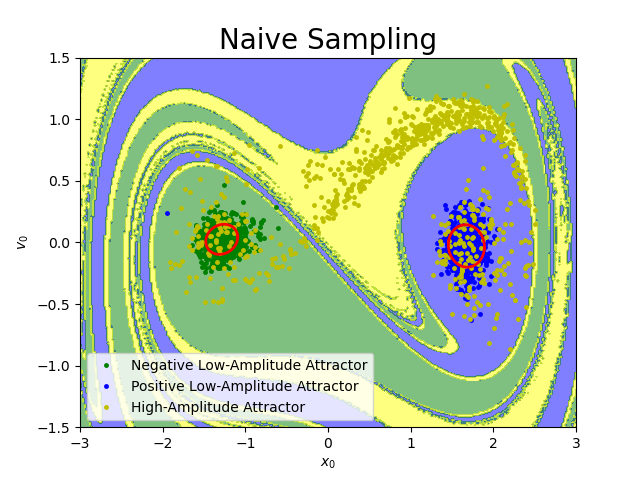

In [7]:
#graphics
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(-1.5, 1.5)
#settings
steps_per_period = 50
dt = Tperiod/steps_per_period
Nperiods = 1000
sigma_naivesampling = 0.05

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)

plt.close()
fig, ax = plt.subplots()
basins = ax.contourf(x0_basins, v0_basins, basins, [-.5, 0.5, 1.5, 2.5], alpha=0.5, colors = ['blue', 'green', 'yellow'])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$v_0$')
ax.set_xlim(-3, 3)
ax.set_ylim(-1.5, 1.5)


xpdata = {}
means = {}
normalized = {}
covariance = {}
angle = {}
for key, attr in attractors_dict.items(): #Do this process at every attractor
    y = attr
    xpdata[key] = np.zeros((Nperiods, 2))
    for n in range(Nperiods):
        t = 0
        for j in range(steps_per_period):
            y, t = Stoch_RKStep(y, t, duff, dt, sigma_naivesampling)
        if n%5==0:
            y = attr
        xpdata[key][n,:] = y
    ax.plot(xpdata[key][:,0], xpdata[key][:,1],'.',markersize=5, c=colors_dict[key], label = labels_dict[key])
    means[key] = np.mean(xpdata[key], 0)
    normalized[key] = xpdata[key] - np.ones((Nperiods, 1))*means[key]
    covariance[key] = 2 * (normalized[key].T@normalized[key]) / Nperiods
    evals, evecs = np.linalg.eig(covariance[key])
    jsort = np.argsort(evals)[::-1]
    esort, vsort = evals[jsort], evecs[:,jsort]
    angle[key] = np.angle(vsort[0,0]+1j*vsort[1,0])

    
for key in attractors_dict:
    if key == 'haa':
        continue
    x, v = plot_ellipse(means[key], covariance[key])
    plt.plot(x, v,linewidth=2, c='r')

np.save('./naive_sampling/nlaamean', means['nlaa'])
np.save('./naive_sampling/nlaacov', covariance['nlaa'])
np.save('./naive_sampling/plaamean', means['plaa'])
np.save('./naive_sampling/plaacov', covariance['plaa'])

# for key, attr in attractors_dict.items():
#     rad = 0.075
#     if key=='haa':
#         rad = 0.015
#         x, v = plot_ellipse(attr, rad*np.array([[5, 1],[1, 1]]))
#         plt.plot(x, v, linewidth=2, c='r')
#     else:
#         x, v = plot_circle(attr, rad)
#         plt.plot(x, v, linewidth=2, c='r')



ax.set_title('Naive Sampling', fontsize=20)
ax.legend()
plt.rcParams['savefig.dpi'] = 300

plt.savefig('./Plots/Naive_Sampling.pdf', format='pdf')
plt.show()

<h1>Sampling with Metadynamics</h1>

In [8]:
def add_bumps_xpt(y,t,RHS,coeffs,xpbumps,fac,fac2,fac3):
    xdiff = y[0] - xpbumps[:,0]
    pdiff = y[1] - xpbumps[:,1]
    mytime = time.time()
    aux = np.exp(-fac2*((xdiff**2)+(pdiff**2)));
    aux1 = np.exp(-fac3*(np.cos(t)-1)**2);
    add2dx = aux1*fac*np.sum(coeffs*xdiff*aux);
    add2dp = aux1*fac*np.sum(coeffs*pdiff*aux);
    dy = RHS(t,y) + np.array([add2dx,add2dp]);
    return dy

<h2>Core Metadynamics</h2>
<p>This code seems to run several orders of magnitude faster in Matlab, and so I didn't actually use the results of the Python code.</p>

In [9]:
metadynamics_flag = False

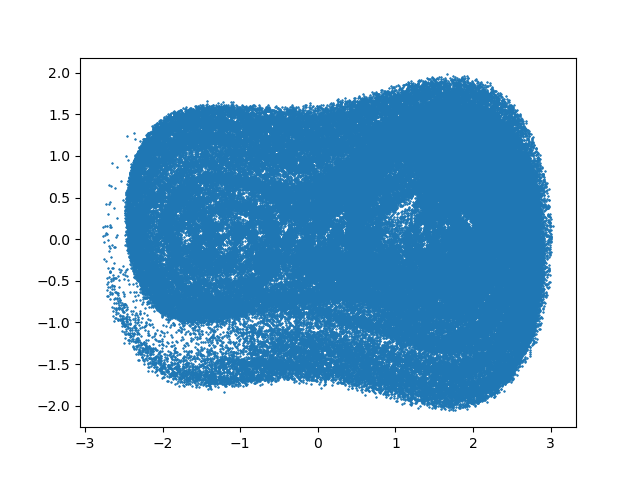

(400000, 2)


In [10]:
if metadynamics_flag:
    # the right-hand side for the corresponding time-dependent ODE
    plt.close()
    fig, ax = plt.subplots()

    Tper = 2*np.pi/omega # period
    #settings
    steps_per_period = 200
    dt = Tper/steps_per_period

    #important parameters
    Ndeposit = 20 # deposit a Gaussian bump after every 10 periods
    Nbumps = 200 # deposit a total of Nbumps Gaussian bumps of the form
    Nperiods = Ndeposit*Nbumps
    iterations = 25
    
    xpdata = np.zeros((Nperiods*iterations,2))


    # A*exp(-0.5*(xp-xpi)^2/s^2)
    # parameters for Gaussian bumps

    for i in range(iterations):
        bump_height = 0.001
        bump_width = 0.1
        fac = bump_height/(bump_width**2)
        fac2 = 0.5/(bump_width**2)
        fac3 = 0.5/((0.125*Tper)**2)
        coeffs = np.zeros((Nbumps,1))
        xpbumps = np.zeros((Nbumps,2))

        # noise level: sigma*dW
        sigma_metadynamics = 0.005

        # start at the high attractor
        y = attractors_dict['haa']
        duff_bumps = lambda t,y: add_bumps_xpt(y,t,duff,coeffs,xpbumps,fac,fac2,fac3)
        nb = 0

        for n in range(Nperiods):

            print(f'Point {n+Nperiods*i}/{Nperiods*iterations}'+' '*10, end='\r')
            t = 0
            for j in range(steps_per_period):
                y,t = Stoch_RKStep(y,t,duff_bumps,dt,sigma_metadynamics)
            xpdata[10*i+n,:] = y
            if n%Ndeposit == 0:
                coeffs[nb] = 1
                xpbumps[nb,:] = y
                duff_bumps = lambda t, y: add_bumps_xpt(y,t,duff,coeffs,xpbumps,fac,fac2,fac3)
                nb += 1

    np.save('./metadynamics/metadynamics_jul27_py.npy', xpdata)
    ax.plot(xpdata[:,0],xpdata[:,1],'.',markersize=5)
    plt.show()
else:
    plt.close()
    fig, ax = plt.subplots()
    #xpdata = np.load('./metadynamics_points_jul20.npy')
    xpdata = np.loadtxt('./metadynamics/metadynamics_jul27_combined.csv', delimiter=',')
    ax.plot(xpdata[:,0],xpdata[:,1],'.',markersize=1)
    plt.show()
    print(xpdata.shape)

<h2>Delta-Net</h2>
<p>This algorithm uses the points generated from metadynamics to construct a roughly uniform set of points</p>

In [11]:
def delta_net(traj, delta, printflag=False):
    #main algorithm
    Z = traj
    Zboolindex = np.zeros(shape=Z.shape[0], dtype='bool')
    Zboolindex[0] = True
    
    for i in range(1, len(Z)):
        if printflag:
            print(f'Looking at point {i}/{len(Z)}', end='\r')
        point = Z[i]
        dists = np.sqrt(np.sum((Z[Zboolindex]-np.reshape(point, (1, -1)))**2, axis=1))
        if dists.min() > delta:
            Zboolindex[i] = True
            
    if printflag:
        print('Finished first pass, looking for outliers')
    Z = Z[Zboolindex]
    Zboolindex = np.full(len(Z), 1, dtype='bool')
    
    for i in range(0, len(Z)):
        if printflag:
            print(f'Looking at point {i}/{len(Z)}', end='\r')
        Zboolindex[i] = False
        point = Z[i]
        
        dists = np.sqrt(np.sum((Z[Zboolindex]-np.reshape(point, (1, -1)))**2, axis=1))
        Zboolindex[i] = True
        if dists.min() > 2*delta:
            Zboolindex[i] = False
    
    Z = Z[Zboolindex]

    return Z

<h3>Estimating the appropriate $\delta$ value</h3>
<p>We must find the appropriate value of $\delta$ for the $\delta$-net algorithm by estimating the eigenvalues of the covariance matrix.

In [12]:
est_cov_flag = False
xpdata = np.loadtxt('./metadynamics/metadynamics_jul27_combined.csv', delimiter=',')
sigma_estcovflag = 0.005
if est_cov_flag:
    xpdata_subsampled = xpdata[::1000]
    Npts_subsampled = xpdata_subsampled.shape[0]
    evals = np.zeros((Npts_subsampled, 2))
    for n in range(Npts_subsampled):
        print(f'Point {n+1}/{Npts_subsampled}', end='\r')
        _, _, evals[n,:] = means_and_covariances(200, 200, Tperiod/200, sigma_estcovflag, duff, xpdata_subsampled[n,:])
    delta_fornet = np.sqrt((0.5*np.mean(np.sqrt(evals[:,0])))**2)
    #np.save('./metadynamics/delta.npy', delta)


    #np.save('./metadynamics/evals.npy', evals)
else: 
    delta_fornet = np.load('./metadynamics/delta.npy')

print(f'Delta = {delta_fornet}')

Delta = 0.017556073632966126


In [13]:
deltanet_flag = False 
if deltanet_flag:
    netted_duffing_metadynamics = delta_net(xpdata, delta, printflag = True)
    np.save('./metadynamics/netted_points_jul27.npy', netted_duffing_metadynamics)
else:
    netted_duffing_metadynamics = np.load('./metadynamics/netted_points_jul25.npy')

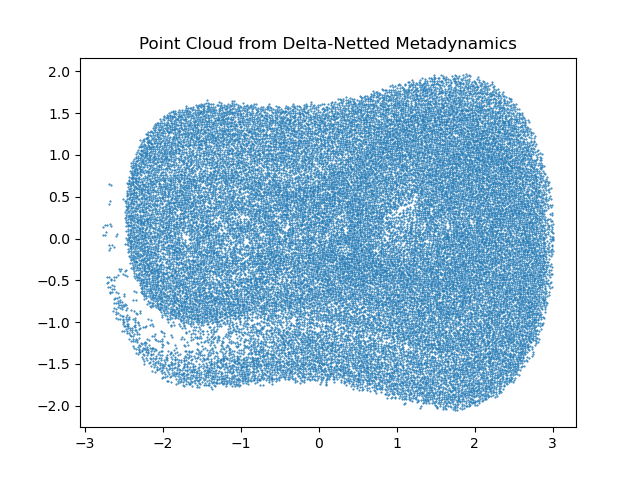

In [14]:
plt.close()
fig, ax = plt.subplots()
ax.plot(netted_duffing_metadynamics[:,0],netted_duffing_metadynamics[:,1],'.', markersize=1)
plt.title('Point Cloud from Delta-Netted Metadynamics')
plt.show()

<h1>Means and Covariances Main</h1>
<p>Here, we attempted to compute the means and covariances of stochastic trajectories launched from each point in the cloud. If the points were modeled well by a Gaussian random variable with some mean and covariance, that would allow us to easily compute the stochastic matrix. However, as we observe, the ellipses plotted from the covariance matrix actually vary in size dramatically, even with a very low noise coefficient.</p>

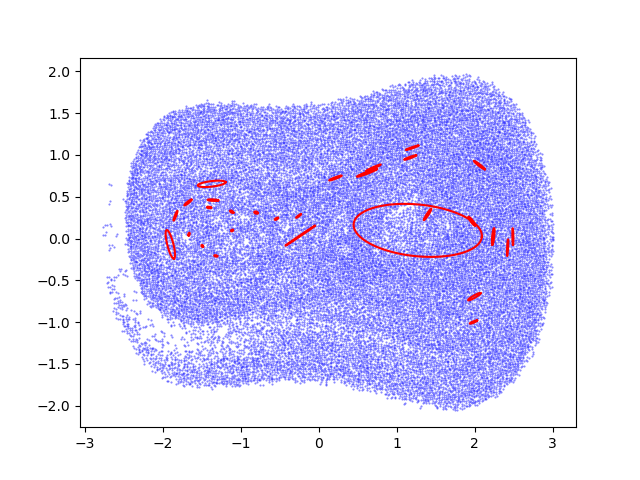

In [15]:
#msandcovs_flag = False
pts = np.load('./metadynamics/netted_points_jul25.npy')
xp, _ = np.unique(pts, axis=0, return_index=True)
Npts = xp.shape[0]
Tperiod = 2*np.pi/omega 
steps_per_period = 200
dt = Tperiod/steps_per_period
Nruns_per_point = 200
sigma_mcov = 0.005

plt.close()
fig, ax = plt.subplots()
ax.plot(xp[:,0], xp[:,1], '.', markersize=1, alpha=0.5, c='b')



for n in range(3, Npts, 1000):
    print(f'On ellipse {int(n/1000)}/{int(Npts/1000)}'+' '*10, end='\r')
    xmean, xcov, _ = means_and_covariances(Nruns_per_point, steps_per_period, dt, sigma_mcov, duff, xp[n,:])
    x, p = plot_ellipse(xmean, xcov)
    ax.plot(x, p, c='r')
#plt.suptitle('Mean and Covariance Ellipses', fontsize=20)
#ax.set_title('Observe the wild variance in size of the ellipses, indicating a problem with the assumption that the trajectories are normally distributed', fontsize=10)
plt.savefig('./Plots/Ellipses.pdf', format='pdf')
plt.show()

<h1>Density of Joker Points</h1>

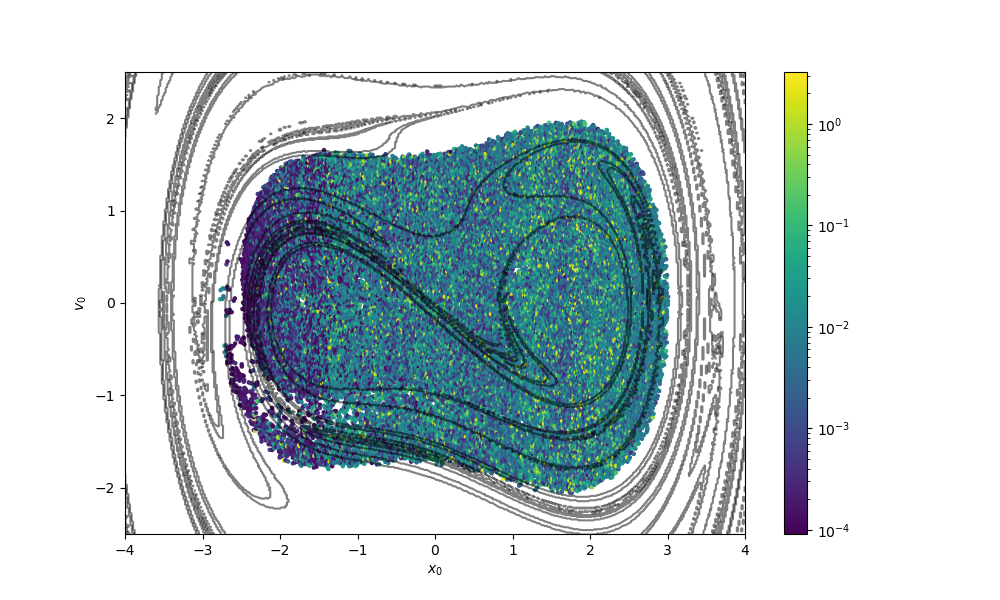

In [16]:
max_evals_flag = False
if max_evals_flag:
    xp = np.load('./metadynamics/netted_points_jul25.npy')
    Npts = xp.shape[0]
    maxevals = np.zeros(Npts)
    Nruns_per_point = 100
    steps_per_period = 100
    dt = Tperiod/steps_per_period
    sigma_jokerpoints = 0.005
    for i in range(Npts):
        y = xp[i] 
        evals = means_and_covariances(Nruns_per_point, steps_per_period, dt, sigma_jokerpoints, duff, y, retall=False)
        maxevals[i] = evals[1]
        print(f'Point {i+1}/{Npts}', end='\r')
    np.save('./mean_and_cov/maxevals.npy', maxevals)
else:
    maxevals = np.load('./mean_and_cov/maxevals.npy')

fig, ax = plt.subplots(figsize=(10, 6))
densityJPplot = ax.scatter(xp[:, 0], xp[:, 1], 5, maxevals, cmap='viridis', norm=mpl.colors.LogNorm())
plt.colorbar(mappable=densityJPplot, ax=ax)

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)


basins = ax.contour(x0_basins, v0_basins, basins, [-.5, 1.5], alpha=0.5, colors='k')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$v_0$')
ax.set_xlim(-4, 4)
ax.set_ylim(-2.5, 2.5)

#plt.savefig('./Plots/Eval_Magnitude.pdf', format='pdf')

plt.show()

<h1>Finding Joker Points</h1>

index: 1918; point: [-1.93782177  0.42729447]; eigenvalues: [0.00127671 0.11778668]
index: 13324; point: [ 0.391425   -1.70452266]; eigenvalues: [0.00706247 0.16095685]
index: 1514; point: [-2.03506448  0.58283377]; eigenvalues: [0.00536652 0.83231454]
index: 21950; point: [ 1.80155254 -1.78513764]; eigenvalues: [0.05524952 0.22404174]
index: 16724; point: [ 0.97722712 -1.91263579]; eigenvalues: [1.35521290e-04 2.36301232e-01]
index: 14473; point: [ 0.58829704 -1.76493281]; eigenvalues: [0.00126147 0.25982065]


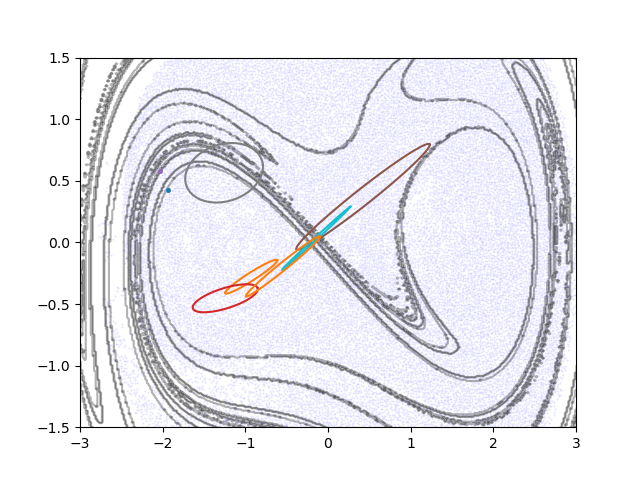

In [17]:
finding_points_flag = True
if finding_points_flag:
    plt.close()
    fig, ax = plt.subplots()
    ax.plot(xp[:,0], xp[:,1], '.', markersize=1 ,c='b', alpha=0.1)
    Npts = xp.shape[0]

    basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
    x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
    v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
    x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)
    ax.contour(x0_basins, v0_basins, basins, [-.5, 0.5, 1.5, 2.5], alpha=0.3, colors = ['k'])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-1.5, 1.5)
    counter = 0
    while counter<=5:
        i = np.random.randint(0, Npts)
        m, c, e = means_and_covariances(200, 200, Tperiod/200, sigma_mcov, duff, xp[i,:])
        if e[1] > 1e-1:
            print(f'index: {i}; point: {xp[i,:]}; eigenvalues: {e}')
            ax.plot(xp[i,0], xp[i,1], '.', markersize=5)
            x, p = plot_ellipse(m, c)
            ax.plot(x, p)
            counter += 1

    plt.show()

<h1>Investigating Joker Points</h1>

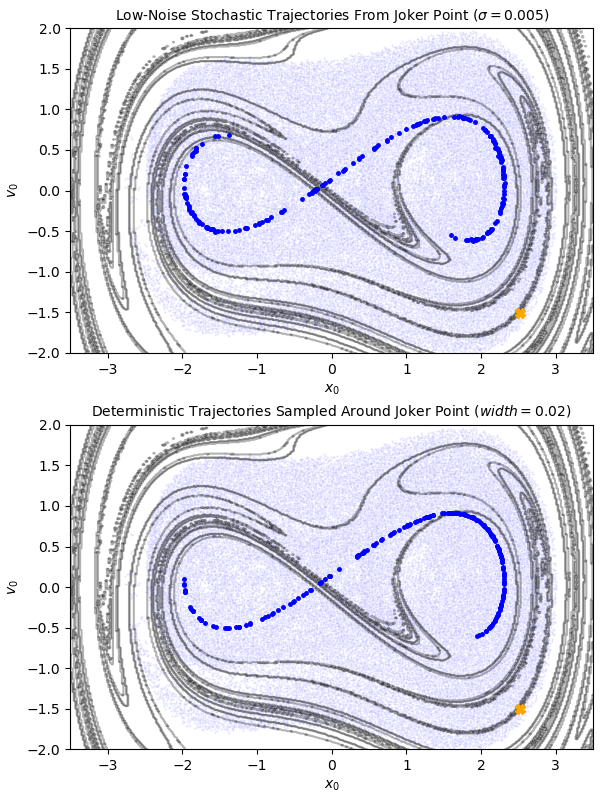

In [18]:
plt.close()
fig, ax = plt.subplots(2, figsize=(6, 8))
ax[0].plot(xp[:,0], xp[:,1], '.', markersize=1 ,c='b', alpha=0.1)
ax[1].plot(xp[:,0], xp[:,1], '.', markersize=1 ,c='b', alpha=0.1)

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)


for a in ax:
    a.contour(x0_basins, v0_basins, basins, [-.5, 0.5, 1.5, 2.5], alpha=0.3, colors = ['k'])
    a.set_xlim(-3.5, 3.5)
    a.set_ylim(-2, 2)
    a.set_xlabel('$x_0$')
    a.set_ylabel('$v_0$')
#ax.set_xlabel('$x_0$')
#ax.set_ylabel('$v_0$')



Nruns_per_point = 200
steps_per_period = 500
num_points = 200
dt = Tperiod/steps_per_period

xp = np.load('./metadynamics/netted_points_jul25.npy')
maxevals = np.load('./mean_and_cov/maxevals.npy')

mjp_index = np.argsort(maxevals)[-1]
mjp = xp[mjp_index]

y0 = mjp# LITERAL OBJECTIVE BEST
#Good points to plot:
#[ 1.41186914, -1.47258025]
#[ 2.30108494, -1.28924537] (personal favorite)
#[ 2.20261136, -0.77818595] (a bit far from contour lines but still good)
#[ 0.37253639, -0.45606495] (elite)
#[ 1.59491711, -1.03209113] (solid)
#[ 2.47855291, -0.18596606] (this one is best for tuned noise)


X = np.zeros((Nruns_per_point,2))
for k in range(Nruns_per_point):
    t = 0
    y = y0
    for j in range(steps_per_period):
        y, t = Stoch_RKStep(y, t, duff, dt, 0.005)
    X[k,:] = y
ax[0].plot(X[:,0], X[:,1], '.', markersize=5, c='b')
ax[0].plot(y0[0], y0[1], 'X', markersize=7, c='orange')
ax[0].set_title('Low-Noise Stochastic Trajectories From Joker Point ($\sigma = 0.005$)', fontsize=10)

bwidth = 2e-2
y0s = np.random.uniform(-1*bwidth/2, bwidth/2, size=(num_points,2)) + y0 
X = np.zeros((num_points, 2))
for i in range(num_points):
    y = y0s[i]
    t = 0
    for j in range(steps_per_period):
        y, t = RKStep(y, t, duff, dt)
    X[i,:] = y
ax[1].plot(X[:,0], X[:,1], '.', c='b', markersize=5)
ax[1].plot(y0[0], y0[1], 'X', markersize=7, c='orange')
ax[1].set_title('Deterministic Trajectories Sampled Around Joker Point ($width=0.02$)', fontsize=10)
#fig.suptitle('\'Joker Points\'', fontsize=20)
fig.tight_layout(pad=0.5)
plt.show()

(2.51710541, -1.50297932)


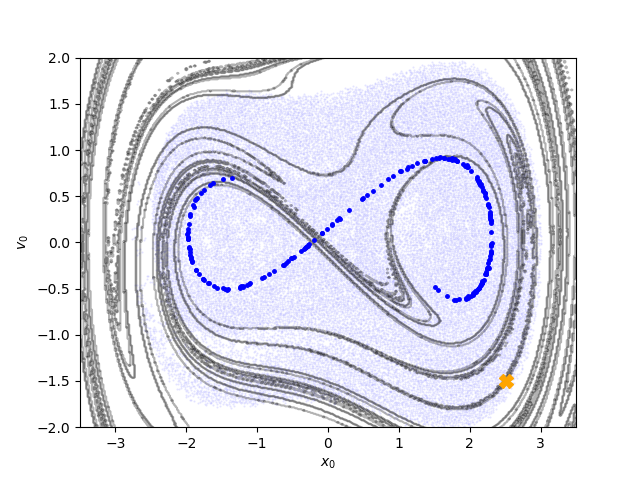

In [19]:
plt.close()
fig, ax = plt.subplots()
ax.plot(xp[:,0], xp[:,1], '.', markersize=1 ,c='b', alpha=0.1)

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)


ax.contour(x0_basins, v0_basins, basins, [-.5, 0.5, 1.5, 2.5], alpha=0.3, colors = ['k'])
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-2, 2)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$v_0$')
#ax.set_xlabel('$x_0$')
#ax.set_ylabel('$v_0$')



Nruns_per_point = 200
steps_per_period = 500
num_points = 200
dt = Tperiod/steps_per_period

y0 = (2.51710541, -1.50297932)#(1.92108581, -1.80264625)# LITERAL OBJECTIVE BEST
#Good points to plot:
#[ 1.41186914, -1.47258025]
#[ 2.30108494, -1.28924537] (personal favorite)
#[ 2.20261136, -0.77818595] (a bit far from contour lines but still good)
#[ 0.37253639, -0.45606495] (elite)
#[ 1.59491711, -1.03209113] (solid)
#[ 2.47855291, -0.18596606] (this one is best for tuned noise)


print(y0)
X = np.zeros((Nruns_per_point,2))
for k in range(Nruns_per_point):
    t = 0
    y = y0
    for j in range(steps_per_period):
        y, t = Stoch_RKStep(y, t, duff, dt, 0.005)
    X[k,:] = y
ax.plot(X[:,0], X[:,1], '.', markersize=5, c='b')
ax.plot(y0[0], y0[1], 'X', markersize=10, c='orange')
#ax[0].set_title('Low-Noise Stochastic Trajectories From Joker Point ($\sigma = 0.005$)', fontsize=10)

#plt.savefig('./Plots/Joker_Point.pdf', format='pdf')
plt.show()

<h1>Computing the Stochastic Matrix</h1>

<h2>Gaussian Approach</h2>
<p>This would result in computing the stochastic matrix IF the trajectories from each point were distributed in a Gaussian manner. Since after experimentation, our oscillator doesn't meet this assumptions, this piece of code is no longer relevant.</p>

<h2>Nearest Neighbor Approach</h2>
<p>This approach, pioneered by Daniel Yuan at last year's REU, involves computing the stochastic matrix by nearest neighbor, running trajectories from each point and considering the nearest element of the point cloud to the point to be the state that it transitions to.</p>

In [20]:
stochmatflag = False
if stochmatflag:
    xp = np.load('./metadynamics/netted_points_jul25.npy')
    Npts = xp.shape[0]
    print(Npts)
    P = sp.sparse.lil_matrix((Npts, Npts))
    sigma_stochmat = 0.005 
    traj_per_point = 500
    steps_per_period = 200
    dt = Tperiod/steps_per_period

    def find_index(array, value):
        array = np.asarray(array)
        idx = (np.linalg.norm(array - value, axis=1)).argmin()
        return idx

    for i in range(Npts):
        print(f'On point {i+1}/{Npts}'+' '*10, end='\r')
        y0 = xp[i,:] 
        traj_points = np.zeros((traj_per_point, 2))
        traj_nearest_indices = np.zeros(traj_per_point, dtype=int)
        for k in range(traj_per_point):
            t = 0
            y = y0
            for j in range(steps_per_period):
                y, t = Stoch_RKStep(y, t, duff, dt, 0.005)
            traj_points[k,:] = y
            traj_nearest_indices[k] = find_index(xp, y)
        unique, counts = np.unique(traj_nearest_indices, return_counts=True)
        for item, num in dict(zip(unique, counts)).items():
            P[i, item] = num/traj_per_point
    sp.sparse.save_npz('./stochastic_matrix/P.npz', sp.sparse.bsr_matrix(P))
else:
    P = np.load('./stochastic_matrix/P.npy')

<h1>Finding A and B Indices</h1>
For the rest of this project, A will be the negative attractor and B will be the positive one. 

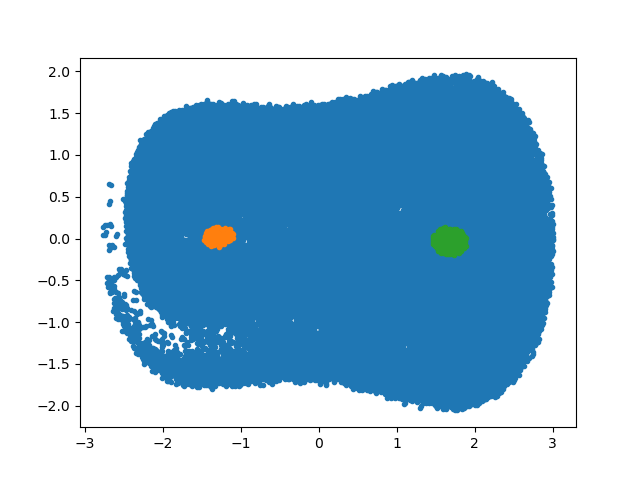

In [21]:
Mdist_max2 = 1
xp = np.load('metadynamics/netted_points_jul25.npy')
Amean = np.load('./naive_sampling/nlaamean.npy')
Acov = np.load('./naive_sampling/nlaacov.npy')
Acov_inv = np.linalg.inv(Acov)
dx = xp[:,0] - Amean[0]
dv = xp[:,1] - Amean[1]
Mah_dist2 = Acov_inv[0,0]*dx**2 + 2*Acov_inv[0, 1]*dx*dv + Acov_inv[1,1]*dv**2
Ainds = np.where(Mah_dist2<Mdist_max2)

Bmean = np.load('./naive_sampling/plaamean.npy')
Bcov = np.load('./naive_sampling/plaacov.npy')
Bcov_inv = np.linalg.inv(Bcov)
dx = xp[:,0]-Bmean[0]
dv = xp[:,1]-Bmean[1]
Mah_dist2 = Bcov_inv[0,0]*dx**2 + 2*Bcov_inv[0,1]*dx*dv + Bcov_inv[1,1]*dv**2
Binds = np.where(Mah_dist2<Mdist_max2)

np.save('./basin_indices/Ainds', Ainds)
np.save('./basin_indices/Binds', Binds)

plt.close()
fig, ax = plt.subplots()
ax.plot(xp[:,0], xp[:,1], '.')
ax.plot(xp[Ainds][:,0], xp[Ainds][:,1], '.')
ax.plot(xp[Binds][:,0], xp[Binds][:,1], '.')
plt.show()



<h1>Finding Forward Committor</h1>

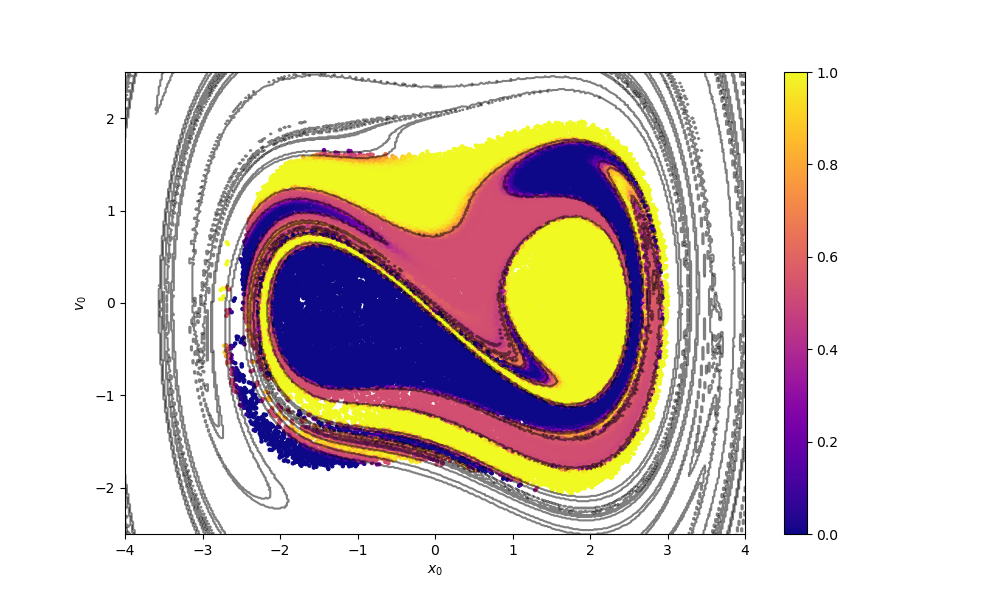

In [4]:
FC_flag = False
xp = np.load('./metadynamics/netted_points_jul25.npy')
if FC_flag:
    Npts = xp.shape[0]
    states = np.arange(Npts)
    P = np.load('./stochastic_matrix/P_aug3.npy')
    
    # P_sparse = P
    P_dense = P

    print(f"Stochastic matrix shape is: {P.shape}")

    # define sets A0 and A1
    Ainds = np.load('./basin_indices/Ainds.npy')
    Binds = np.load('./basin_indices/Binds.npy')
    qplus = np.zeros(Npts)
    qplus = qplus.reshape(Npts, 1)
    qplus[Binds] = 1

    L = P_dense - np.eye(Npts, Npts)  # the generator matrix    
    RHS = -L @ qplus
    ABinds = np.union1d(Ainds, Binds)
    notAB = np.setdiff1d(states, ABinds)
    qplus[notAB] = np.linalg.solve(L[notAB][:, notAB], RHS[notAB])
    qplus = np.minimum(qplus, 1)

    np.save('./committors/qplus_aug3.npy', qplus)
else:
    qplus = np.load('./committors/qplus_aug3.npy')
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)


basins = ax.contour(x0_basins, v0_basins, basins, [-.5, 1.5], alpha=0.5, colors='k')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$v_0$')
ax.set_xlim(-4, 4)
ax.set_ylim(-2.5, 2.5)


complot = ax.scatter(xp[:, 0], xp[:, 1], 5, qplus, cmap='plasma')
# xp0 = np.array([1.03697453e+00, 6.29229877e-02])
# xp1 = np.array([1.96179192e-01,  4.00391095e-02])
# plt.plot(xp0[0], xp0[1], marker='o', markersize=8, color='cyan')
# plt.plot(xp1[0], xp1[1], marker='o', markersize=8, color='cyan')
fig.colorbar(mappable=complot, ax=ax)
#plt.title('Forward Committor', fontsize=20)

plt.savefig('./Plots/Forward_Committor.pdf', format='pdf')
plt.show()

<h1>Committor and Eigenvalue Plot</h1>

ValueError: 'c' argument has 14815 elements, which is inconsistent with 'x' and 'y' with size 1900.

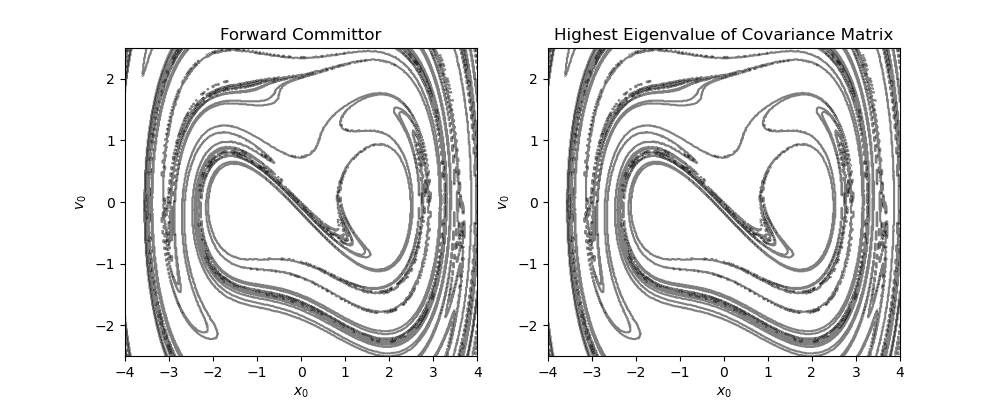

In [26]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)

for a in ax:
    a.contour(x0_basins, v0_basins, basins, [-.5, 1.5], alpha=0.5, colors='k')
    a.set_xlabel('$x_0$')
    a.set_ylabel('$v_0$')
    a.set_xlim(-4, 4)
    a.set_ylim(-2.5, 2.5)

ax[0].set_title('Forward Committor')
ax[1].set_title('Highest Eigenvalue of Covariance Matrix')

complot = ax[0].scatter(xp[:, 0], xp[:, 1], 4, qplus, cmap='plasma')
eigplot = ax[1].scatter(xp[:, 0], xp[:, 1], 4, maxevals, cmap='viridis', norm=mpl.colors.LogNorm())

<h1>Finding Strongly Connected Component</h1>

{0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 16418, 16427, 8235, 8239, 24634, 8279, 8283, 8284, 8285, 8290, 8297, 8299, 16493, 8324, 8327, 8331, 16538, 8378, 8388, 8411, 8417, 8429, 8435, 8440, 24828, 8462, 8468, 8471, 24865, 8486, 8487, 8489, 8502, 347, 16748, 8565, 8574, 16773, 8589, 8591, 24979, 404, 405, 406, 8612, 8615, 8617, 8629, 438, 439, 440, 441, 442, 446, 447, 8643, 25044, 8664, 480, 8672, 8677, 8693, 8694, 8710, 521, 522, 523, 524, 8714, 528, 529, 8724, 8739, 8744, 555, 16971, 8795, 611, 8804, 613, 614, 25210, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 8859, 8861, 679, 680, 17063, 8879, 712, 717, 718, 719, 720, 721, 8912, 8928, 17155, 8965, 8967, 17171, 8991, 9000, 9016, 825, 9066, 17259, 879, 881, 9077, 25462, 9078, 9088, 9089, 9098, 918, 919, 9112, 920, 9119, 9134, 959, 960, 961, 962, 963, 964, 965, 966, 967, 972, 973, 974, 975, 976, 977, 978, 979, 17371, 1004, 1005, 1006, 17395, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 9223, 25610, 17427, 1045, 1046, 1047, 9241, 9

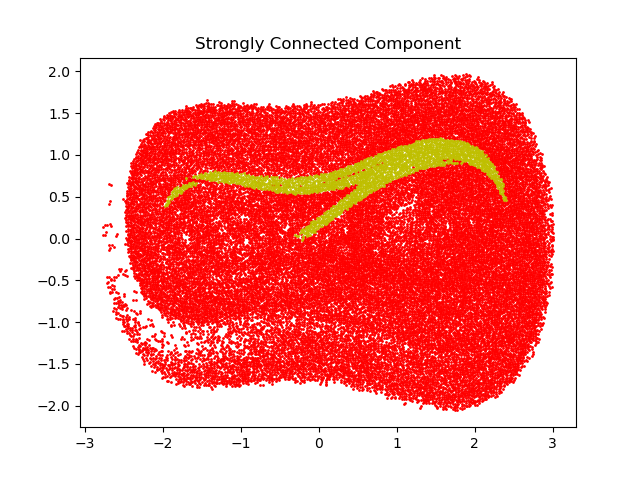

In [24]:
scc_flag = True

P = np.load('./stochastic_matrix/P_aug3.npy')
xp = np.load('./metadynamics/netted_points_jul25.npy')
Npts = xp.shape[0]

Amean = np.load('./naive_sampling/nlaamean.npy')
Acov = np.load('./naive_sampling/nlaacov.npy')


Bmean = np.load('./naive_sampling/plaamean.npy')
Bcov = np.load('./naive_sampling/plaacov.npy')

if scc_flag:
    graph_P = nx.from_numpy_array(P, create_using=nx.DiGraph)
    sccs = sorted(nx.strongly_connected_components(graph_P), key=len, reverse=True)
    print(sccs[0])
    print(sccs[1])
    print(sccs[2])
    print(sccs[3])
    lcc = sccs[0]
    lcc = np.fromiter(lcc, int, len(lcc))
    
    to_remove = np.setdiff1d(range(Npts),lcc)
    
    
    xp_pruned = np.delete(xp, to_remove, axis=0)
    P_pruned = np.delete(np.delete(P, to_remove, axis=0), to_remove, axis=1)
    maxevals_pruned = np.delete(maxevals, to_remove, axis=0)
    

    
    Mdist_max2 = 1

    Acov_inv = np.linalg.inv(Acov)
    dx = xp_pruned[:,0] - Amean[0]
    dv = xp_pruned[:,1] - Amean[1]
    Mah_dist2 = Acov_inv[0,0]*dx**2 + 2*Acov_inv[0, 1]*dx*dv + Acov_inv[1,1]*dv**2
    Ainds = np.where(Mah_dist2<Mdist_max2)

    Bcov_inv = np.linalg.inv(Bcov)
    dx = xp_pruned[:,0]-Bmean[0]
    dv = xp_pruned[:,1]-Bmean[1]
    Mah_dist2 = Bcov_inv[0,0]*dx**2 + 2*Bcov_inv[0,1]*dx*dv + Bcov_inv[1,1]*dv**2
    Binds = np.where(Mah_dist2<Mdist_max2)

    
    np.save('./scc/lcc.npy', lcc)
    np.save('./scc/to_remove.npy', to_remove)
    np.save('./scc/xp_pruned.npy', xp_pruned)
    np.save('./scc/P_pruned.npy', P_pruned)
    np.save('./scc/maxevals_pruned.npy', maxevals_pruned)

    
    np.save('./basin_indices/Ainds_pruned.npy', Ainds)
    np.save('./basin_indices/Binds_pruned.npy', Binds)
else:
    lcc = np.load('./scc/lcc.npy')
    to_remove = np.load('./scc/to_remove.npy')  
    xp_pruned = np.load('./scc/xp_pruned.npy')
    P_pruned = np.load('./scc/P_pruned.npy')
    maxevals_pruned = np.load('./scc/maxevals_pruned.npy')
    Ainds = np.squeeze(np.load('./basin_indices/Ainds_pruned.npy'))
    Binds = np.squeeze(np.load('./basin_indices/Binds_pruned.npy'))

plt.close()
fig, ax = plt.subplots()
ax.plot(xp[to_remove][:,0], xp[to_remove][:,1], '.', c='r', markersize=2, label='Points to Remove')

ax.plot(xp_pruned[:,0], xp_pruned[:,1], '.', c='y', markersize=2, label='Points to Keep')
ax.plot(xp_pruned[Ainds][:,0], xp_pruned[Ainds][:,1], '.', c='b', markersize=2, label='A indices')
ax.plot(xp_pruned[Binds][:,0], xp_pruned[Binds][:,1], '.', c='g', markersize=2, label='B indices')

ax.set_title('Strongly Connected Component')
plt.show()

<h1>Forward Committor on Strongly Connected Component</h1>

ValueError: 'c' argument has 14815 elements, which is inconsistent with 'x' and 'y' with size 1900.

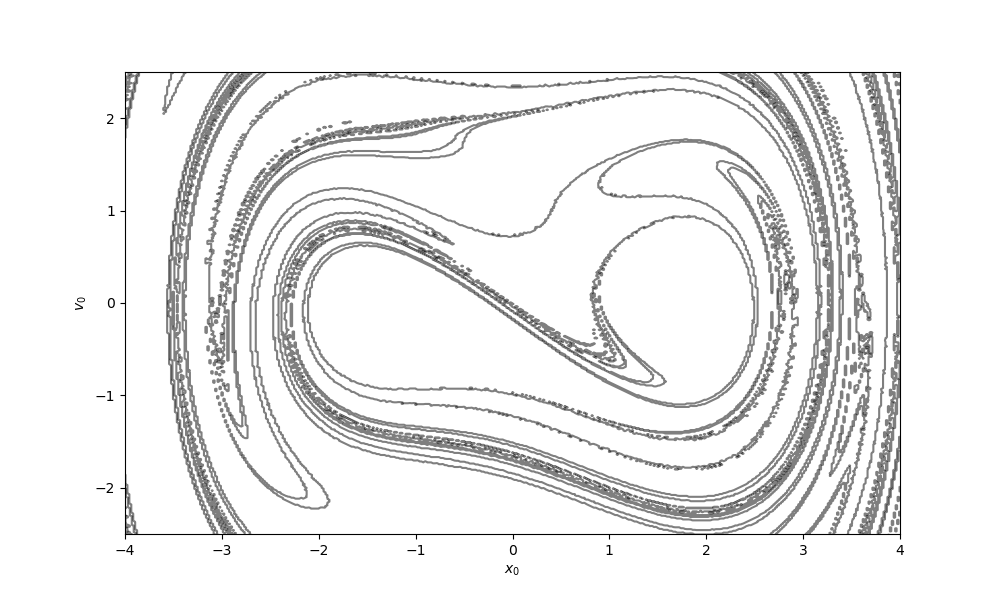

In [3]:
FC_SCC_flag = False
xp = np.load('./scc/xp_pruned.npy')
Npts = xp.shape[0]

if FC_SCC_flag:
    states = np.arange(Npts)
    P = np.load('./scc/P_pruned.npy')
    print(f'Npts = {Npts}')
    
    # P_sparse = P
    P_dense = P

    print(f"Stochastic matrix shape is: {P.shape}")

    # define sets A0 and A1
    Ainds = np.load('./basin_indices/Ainds_pruned.npy')
    Binds = np.load('./basin_indices/Binds_pruned.npy')
    qplus = np.zeros(Npts)
    qplus = qplus.reshape(Npts, 1)
    qplus[Binds] = 1

    L = P_dense - np.eye(Npts, Npts)  # the generator matrix    
    RHS = -L @ qplus
    ABinds = np.union1d(Ainds, Binds)
    notAB = np.setdiff1d(states, ABinds)
    qplus[notAB] = np.linalg.solve(L[notAB][:, notAB], RHS[notAB])
    qplus = np.minimum(qplus, 1)

    np.save('./committors/qplus_cropped.npy', qplus)
else:
    qplus = np.load('./committors/qplus_cropped.npy')
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))

basins = np.genfromtxt('./basins/basin.csv', delimiter=',')
x0_raw = np.genfromtxt('./basins/x0.csv', delimiter=',')
v0_raw = np.genfromtxt('./basins/v0.csv', delimiter=',')
x0_basins, v0_basins = np.meshgrid(x0_raw, v0_raw)


basins = ax.contour(x0_basins, v0_basins, basins, [-.5, 1.5], alpha=0.5, colors='k')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$v_0$')
ax.set_xlim(-4, 4)
ax.set_ylim(-2.5, 2.5)


complot = ax.scatter(xp[:, 0], xp[:, 1], 5, qplus, cmap='plasma')
# xp0 = np.array([1.03697453e+00, 6.29229877e-02])
# xp1 = np.array([1.96179192e-01,  4.00391095e-02])
# plt.plot(xp0[0], xp0[1], marker='o', markersize=8, color='cyan')
# plt.plot(xp1[0], xp1[1], marker='o', markersize=8, color='cyan')
fig.colorbar(mappable=complot, ax=ax)
#plt.title('Forward Committor', fontsize=20)

#plt.savefig('./Plots/Forward_Committor', format='pdf')
plt.show()

<h1>Invariant Distribution</h1>

In [ ]:
xp = np.load('./scc/xp_pruned.npy')
P = np.load('./scc/P_pruned.npy')
V, E = np.linalg.eig(P.T)


In [ ]:
    data = load('qplus.mat');
    xp = data.xp;
    P = data.P;
    [V,E] = eigs(P');
    [esort,jsort] = sort(diag(E),'descend');
    fprintf('%d\n',esort);
    V = V(:,jsort);
    mu = V(:,1);
    mu = mu/sum(mu);
    scatter(xp(:,1),xp(:,2),40,mu,'filled');
    colorbar;
    clim([min(mu),max(mu)]);
    save('invariant_mu.mat','xp','P','mu');

<h1>Finding Backward Committor</h1>

In [ ]:
BC_flag = True
if BC_flag:
    

<h1>Notes on analytic computation</h1>

For update seminar, both give quick presentation on oscillators. Start with linear oscillators, no forcing, on phase space just ellipse. add nonlinear cubic term, add forcing. 

when plot periodic solution of period 2pi/omega, see smooth graph. if i look at small gamma, see two periodic solutions of low amplitude around stable equilibria are just ellipses. 

Any smooth periodic function can be represented by fourier series. Decay depends on smoothness of the function. In our case infinitely smooth - so coefficients must decay exponentially fast. So 

$x(t)=a_0+\sum_{n=1}^\infty a_n\cos(n\omega t)+b_n\sin(n\omega t)$ where $\omega$ is the frequency of the external forcing.
We can find the coefficients analytically. 
    
$v(t)=\sum_{n=1}^\infty -a_n n\omega\sin(n\omega t)+b_n n\omega\cos(n\omega t)$

$\dot v(t)=\sum_{n=1}^\infty -a_nn^2\omega^2\cos(n\omega t)-b_nn^2\omega^2\sin(n\omega t)$

$\dot v = -cv-k_1x-k_3x^3+\gamma \cos\omega t$

Substitute shit into the original equation. Then we get equation for $a_0$: $k_1a_0+k_3a_0^3=0$ which means that $a_0=0$ or if $k_3/k_1<0$, we have $a_0=\pm\sqrt{k_1/k_3}$

$\cos\omega t$: you can easily find a and b if there was no $x^3$ term, but nonlinearity makes it harder to find solutions. Then here we can use the $\cos^3$ identity when plugging things in. 

Trick: seperately equate all harmonics. Make all coefficients next to sin and cos sum to zero. Might not totally understand that one. Not so bad because they decay fast? 

Can solve for $a_1, b_1$ usign just ?? f0? we can solve numerically, graphically find zeros to func. might work to some extent, but why do we have chaotic regions? unstable periodic solutions. apparently no stable periodic solution in chaotic region, but there may still be a solution. In general, this becomes complicated, someone might want to use computer algebra to solve, cubic formulas for trig functions. Maybe for bigger gamma? 

Might stop having real solutions? why? 

For my system, three solutions with small gamma, can definitely get them analytically and fourier coefficients vanish, but as gamma grows then we get the large solution. 

We create this energy function looking thing but where does ti come from still not 100%

$H(t)=\frac{v^2}{2}+k_1/2x^2+k_3/4x^4$ 

$dH/dt=dH/dx dx/dy+dH/dv dv/dt$ note that $dx/dt=v$ and $dv/dt=-cv-u'(x)+\gamma\cos\omega t$

$=u'(x)v+v(-cv-U/(x)+\gamma\cos\omega t)$
$=U'(x)v-v^2c-vU'(x)+v\gamma\cos\omega t$
$=-cv^2+v\gamma\cos\omega t$
So the energy is always decreasing. This means that with Fourier series, it will decay to zero. 

Because our solutions are periodic, energy is conserved. 

$\int_0^{\frac{2\pi}{\omega}}\frac{dH}{dt}dt=0=\int_0^{2\pi/\omega}(-cv^2+v\gamma\cos\omega t)dt$

That might be helpful to find some coefficients. v is a trigonometric series, so when we integrate sines and cosines over a period, there's an orthogonality relationship between them. $\int_0^{\frac{2\pi}{\omega}}$smth is equal to 0, their products or something like that, inner product, makes sense

This relationship might be helpful in finding coefficients. ODEs/PDEs: manipulation of fourier series is very important or something. 

This seems promising? idk 

Previously, periodic solutions were so simple that it seems like the fourier coefficients should have decayed so fast that solutions could be obtained analytically. 

<h1>Notes August 1</h1>

We grid the basin boundaries 

Next step - do what daniel did basically 

<h1>Organizing Poster</h1>

three columns, first one introduction with equation, explain the different parts. Abjini's part idk. Daniel and I each get a column. She's hoping that before 4:00 pm, we can do like a rough sketch of poster. Necessary figures: bifurcation diagrams, specification of parameters, something with sampling. Emphasize the weird points, emphasize why the technique doesn't work, tiny perturbation in initial condition. High divergence. 